Setup complete!

Dataset Overview:
Time Range: 2015-02-21 21:28:19+00:00 to 2018-03-22 16:39:15+00:00
Number of readings: 456444
Sampling frequency: 0 days 00:03:32.913016521

Basic statistics of DO values:
count    456444.000000
mean          9.123842
std           2.074245
min           0.000000
25%           8.170000
50%           8.920000
75%           9.980000
max          41.470000
Name: value, dtype: float64

Data Quality Assessment:

Missing Values:
sensor_id    452157
stderr       456444
dtype: int64

Value Ranges:
DO Range: 0.00 to 41.47 mg/L

Time Gaps:
Minimum gap: 0 days 00:00:00
Maximum gap: 124 days 22:51:25
Mean gap: 0 days 00:03:32.913016521

Duplicate timestamps: 343


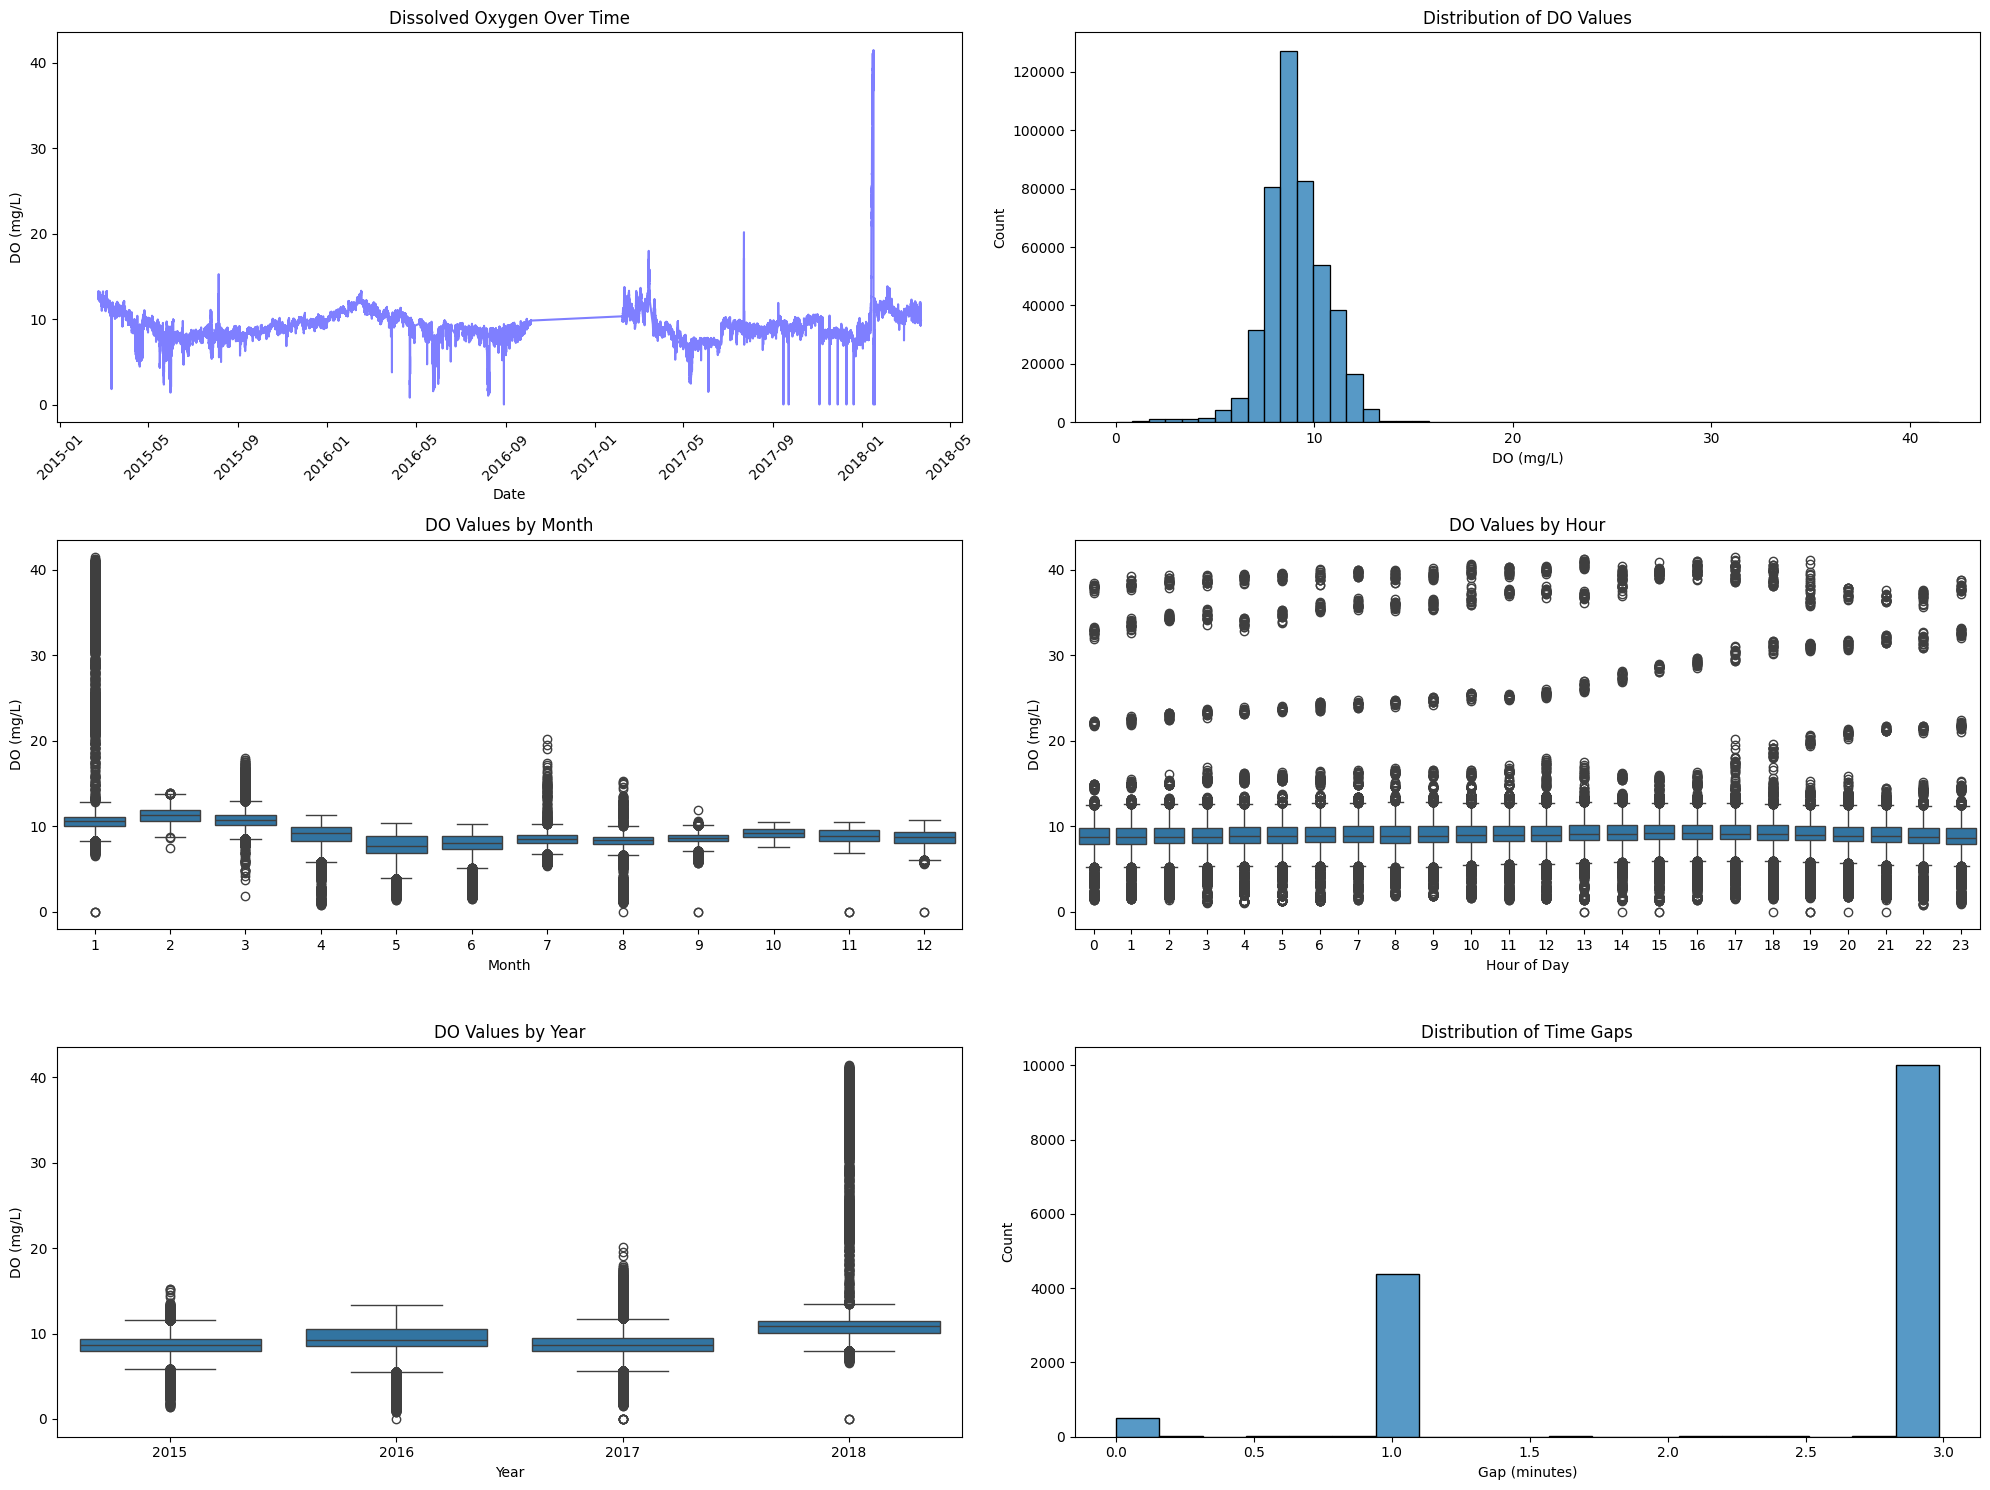

Epoch 1/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.3687 - val_loss: 4.7603
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0486 - val_loss: 2.6906
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0367 - val_loss: 2.6581
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0292 - val_loss: 1.4511
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0249 - val_loss: 1.2234
Epoch 6/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0215 - val_loss: 0.6987
Epoch 7/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0197 - val_loss: 0.3911
Epoch 8/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0173 - val_loss: 0.2451
Epoch 9/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0169 - val_loss: 0.4669
Epoch 10/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0157 - val_loss: 0.1369
Epoch 11/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0149 - val_loss: 0.1820
Epoch 12/50
675/675 ━━━━━━━━━━━━━━━━━━━━


Analyzing anomaly at 2018-01-13 20:00:00:
Peak value: 24.49 mg/L
Duration above normal: 20 measurements
Maximum prediction error: 1.76

Anomaly Detection Summary:
Total observations: 26972
Total anomalies detected: 356
Sensor faults: 12
Environmental anomalies: 344

Model Training Results:
Final training loss: 0.0131
Final validation loss: 0.4066

Temporal Distribution of Anomalies:
month
1     59
2     13
3     37
4     18
5     96
6     26
7      8
8     90
9      4
11     4
12     1
dtype: int64


In [7]:
# Water Quality Analysis System: LEWAS Lab
# ML-based Anomaly Detection for Dissolved Oxygen Data

## 1. Setup and Configuration
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Statistical analysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Setup complete!")

## 2. Data Loading and Initial Processing
def load_do_data(file_path='water_DO.csv'):
    """
    Load and process LEWAS Lab dissolved oxygen data with proper datetime parsing.
    """
    # Read CSV without parsing dates first
    df = pd.read_csv(file_path)
    
    # Convert to datetime with UTC=True to handle timezones properly
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
    
    # Sort by datetime
    df = df.sort_values('datetime')
    
    print("\nDataset Overview:")
    print(f"Time Range: {df['datetime'].min()} to {df['datetime'].max()}")
    print(f"Number of readings: {len(df)}")
    print(f"Sampling frequency: {df['datetime'].diff().mean()}")
    print("\nBasic statistics of DO values:")
    print(df['value'].describe())
    
    return df

## 3. Data Quality Assessment
def assess_data_quality(df):
    """
    Perform comprehensive data quality assessment.
    """
    print("\nData Quality Assessment:")
    
    # Check for missing values
    missing = df.isnull().sum()
    print("\nMissing Values:")
    print(missing[missing > 0])
    
    # Check value ranges
    print("\nValue Ranges:")
    print(f"DO Range: {df['value'].min():.2f} to {df['value'].max():.2f} mg/L")
    
    # Calculate time gaps
    time_gaps = df['datetime'].diff()
    print("\nTime Gaps:")
    print(f"Minimum gap: {time_gaps.min()}")
    print(f"Maximum gap: {time_gaps.max()}")
    print(f"Mean gap: {time_gaps.mean()}")
    
    # Check for duplicates
    duplicates = df.duplicated('datetime').sum()
    print(f"\nDuplicate timestamps: {duplicates}")
    
    return {
        'missing_values': missing,
        'time_gaps': time_gaps,
        'duplicates': duplicates
    }

## 4. Data Visualization
def create_visualizations(df):
    """
    Create comprehensive visualizations of the DO data.
    """
    # Create a copy of the dataframe
    df = df.copy()
    
    # Convert to naive datetime for plotting
    df['datetime'] = df['datetime'].dt.tz_localize(None)
    
    # Add time-based features
    df['hour'] = df['datetime'].dt.hour
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Time series plot
    plt.subplot(3, 2, 1)
    plt.plot(df['datetime'], df['value'], 'b-', alpha=0.5)
    plt.title('Dissolved Oxygen Over Time')
    plt.xlabel('Date')
    plt.ylabel('DO (mg/L)')
    plt.xticks(rotation=45)
    
    # 2. Distribution plot
    plt.subplot(3, 2, 2)
    sns.histplot(data=df, x='value', bins=50)
    plt.title('Distribution of DO Values')
    plt.xlabel('DO (mg/L)')
    
    # 3. Box plot by month
    plt.subplot(3, 2, 3)
    sns.boxplot(data=df, x='month', y='value')
    plt.title('DO Values by Month')
    plt.xlabel('Month')
    plt.ylabel('DO (mg/L)')
    
    # 4. Daily pattern
    plt.subplot(3, 2, 4)
    sns.boxplot(data=df, x='hour', y='value')
    plt.title('DO Values by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('DO (mg/L)')
    
    # 5. Values by year
    plt.subplot(3, 2, 5)
    sns.boxplot(data=df, x='year', y='value')
    plt.title('DO Values by Year')
    plt.xlabel('Year')
    plt.ylabel('DO (mg/L)')
    
    # 6. Time gaps analysis
    plt.subplot(3, 2, 6)
    time_gaps = df['datetime'].diff().dt.total_seconds() / 60
    sns.histplot(time_gaps[time_gaps < time_gaps.quantile(0.95)])
    plt.title('Distribution of Time Gaps')
    plt.xlabel('Gap (minutes)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

## 5. Data Preprocessing
def preprocess_data(df, resample_freq='1H'):
    """
    Preprocess the DO data for ML-based anomaly detection.
    """
    # Create copy of the data
    df_copy = df.copy()
    
    # Convert to naive datetime for processing
    df_copy['datetime'] = df_copy['datetime'].dt.tz_localize(None)
    
    # Set datetime as index
    df_copy.set_index('datetime', inplace=True)
    
    # Resample data to regular intervals
    df_resampled = df_copy['value'].resample(resample_freq).mean()
    
    # Handle missing values
    df_resampled = df_resampled.interpolate(method='linear')
    
    # Create processed DataFrame
    processed_df = pd.DataFrame(
        df_resampled.values,
        index=df_resampled.index,
        columns=['value']
    )
    
    return processed_df

## 6. ML-based Anomaly Detection
def create_sequences(data, seq_length):
    """
    Create sequences for LSTM training
    """
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

def build_lstm_model(seq_length):
    """
    Build LSTM model architecture
    """
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def detect_anomalies_lstm(df, seq_length=24, threshold_multiplier=3):
    """
    Detect anomalies using LSTM
    """
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df['value'].values.reshape(-1, 1))
    
    # Create sequences
    X, y = create_sequences(scaled_data, seq_length)
    
    # Split data
    train_size = int(len(X) * 0.8)
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]
    
    # Build and train model
    model = build_lstm_model(seq_length)
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Make predictions
    predictions = model.predict(X)
    
    # Calculate reconstruction error
    reconstruction_error = np.mean(np.abs(predictions - y), axis=1)
    error_threshold = np.mean(reconstruction_error) + threshold_multiplier * np.std(reconstruction_error)
    
    # Detect anomalies
    anomalies = reconstruction_error > error_threshold
    
    # Create results DataFrame
    results = pd.DataFrame()
    results.index = df.index[seq_length:]
    results['original_value'] = df['value'].values[seq_length:]
    results['predicted_value'] = scaler.inverse_transform(predictions).flatten()
    results['reconstruction_error'] = reconstruction_error
    results['is_anomaly'] = anomalies
    
    # Classify anomaly types
    results['anomaly_type'] = 'normal'
    results.loc[results['is_anomaly'], 'anomaly_type'] = 'environmental'
    
    # Identify sensor faults (sudden large changes)
    value_diff = results['original_value'].diff().abs()
    results.loc[
        (results['is_anomaly']) & 
        (value_diff > 3), 'anomaly_type'] = 'sensor_fault'
    
    return results, model, history

def analyze_anomaly_event(df, event_time, window_hours=12):
    """
    Analyze a specific anomaly event in detail.
    """
    window_start = pd.to_datetime(event_time) - pd.Timedelta(hours=window_hours)
    window_end = pd.to_datetime(event_time) + pd.Timedelta(hours=window_hours)
    
    event_data = df[window_start:window_end].copy()
    
    print(f"\nAnalyzing anomaly at {event_time}:")
    print(f"Peak value: {event_data['original_value'].max():.2f} mg/L")
    print(f"Duration above normal: {len(event_data[event_data['is_anomaly']])} measurements")
    print(f"Maximum prediction error: {event_data['reconstruction_error'].max():.2f}")
    
    return event_data

## 7. Visualize Results
def plot_anomalies(df):
    """
    Create interactive visualization of ML-based anomaly detection results
    """
    fig = go.Figure()
    
    # Plot original data
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['original_value'],
        mode='lines',
        name='Original Data',
        line=dict(color='blue', width=1)
    ))
    
    # Plot predicted values
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['predicted_value'],
        mode='lines',
        name='LSTM Predictions',
        line=dict(color='green', width=1, dash='dash')
    ))
    
    # Plot sensor faults
    sensor_faults = df[df['anomaly_type'] == 'sensor_fault']
    if not sensor_faults.empty:
        fig.add_trace(go.Scatter(
            x=sensor_faults.index,
            y=sensor_faults['original_value'],
            mode='markers',
            name='Sensor Faults',
            marker=dict(color='red', size=8, symbol='x')
        ))
    
    # Plot environmental anomalies
    env_anomalies = df[df['anomaly_type'] == 'environmental']
    if not env_anomalies.empty:
        fig.add_trace(go.Scatter(
            x=env_anomalies.index,
            y=env_anomalies['original_value'],
            mode='markers',
            name='Environmental Anomalies',
            marker=dict(color='orange', size=8, symbol='circle')
        ))
    
    # Update layout
    fig.update_layout(
        title="LSTM-based Dissolved Oxygen Anomaly Detection",
        xaxis_title="DateTime",
        yaxis_title="Dissolved Oxygen (mg/L)",
        showlegend=True,
        template="plotly_white",
        height=600
    )
    
    fig.show()

## 8. Analysis Summary
def create_summary(df, history=None):
    """
    Create a summary of the ML-based anomaly detection results
    """
    print("\nAnomaly Detection Summary:")
    print(f"Total observations: {len(df)}")
    print(f"Total anomalies detected: {df['is_anomaly'].sum()}")
    print(f"Sensor faults: {(df['anomaly_type'] == 'sensor_fault').sum()}")
    print(f"Environmental anomalies: {(df['anomaly_type'] == 'environmental').sum()}")
    
    if history:
        print("\nModel Training Results:")
        print(f"Final training loss: {history.history['loss'][-1]:.4f}")
        print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
    
    print("\nTemporal Distribution of Anomalies:")
    df['month'] = df.index.month
    monthly_anomalies = df[df['is_anomaly']].groupby('month').size()
    print(monthly_anomalies)

## Main Execution
if __name__ == "__main__":
    # Load data
    do_data = load_do_data('water_DO.csv')
    
    # Assess data quality
    quality_metrics = assess_data_quality(do_data)
    
    # Create visualizations
    create_visualizations(do_data)
    
    # Preprocess data
    processed_data = preprocess_data(do_data)
    
    # Detect anomalies using LSTM
    results, model, history = detect_anomalies_lstm(processed_data)
    
    # Plot results
    plot_anomalies(results)
    
    # Analyze high anomalies
    high_anomalies = results[results['original_value'] > 20]
    if not high_anomalies.empty:
        spike_time = high_anomalies.index[0]
        spike_analysis = analyze_anomaly_event(results, spike_time)
    
    # Create summary
    create_summary(results, history)